In [1]:
from pathlib import Path

is_colab = True

try:
    from google.colab import drive

    drive.mount('/content/drive')
except ModuleNotFoundError:
    is_colab = False

print("Is running colab?", is_colab)

Is running colab? False


In [2]:
if is_colab:
    data_dir = Path('/content/drive/MyDrive/data')
    code_dir = Path('/content/drive/MyDrive/code')
    models_dir = Path('/content/drive/MyDrive/models/rnn')
else:
    data_dir = Path('data').resolve()
    models_dir = Path('models').resolve()

print(data_dir)

D:\ai-roadmap\content\dl\language_modelling\rnn\data


In [3]:
if is_colab:
    import shutil
    shutil.copy(code_dir / 'rnn/dataset.py',
                'dataset.py')

    shutil.copy(code_dir / 'rnn/chars.json',
                'chars.json')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from dataset import get_all_stories, get_dataset, CharacterLevelTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cpu


In [5]:
train_stories, val_stories, test_stories = get_all_stories(data_dir)

In [6]:
tokenizer = CharacterLevelTokenizer()
vocab_size = tokenizer.vocab_size

In [7]:
block_size=8
Ds_tr = get_dataset(train_stories, tokenizer, block_size=block_size)
Ds_val = get_dataset(val_stories, tokenizer, block_size=block_size)
Ds_test = get_dataset(test_stories, tokenizer, block_size=block_size)

In [8]:
Xtr, Ytr = Ds_tr.tensors
Xval, Yval = Ds_val.tensors

In [9]:
print(Xtr)
print(Ytr)

tensor([[ 0, 14,  2,  ..., 35, 18, 27],
        [14,  2, 31,  ..., 18, 27,  2],
        [ 2, 31, 14,  ..., 27,  2, 14],
        ...,
        [46,  2, 55,  ..., 45, 58, 59],
        [ 2, 55, 60,  ..., 58, 59,  8],
        [55, 60, 48,  ..., 59,  8, 40]])
tensor([[14,  2, 31,  ..., 18, 27,  2],
        [ 2, 31, 14,  ..., 27,  2, 14],
        [31, 14, 35,  ...,  2, 14, 27],
        ...,
        [ 2, 55, 60,  ..., 58, 59,  8],
        [55, 60, 48,  ..., 59,  8, 40],
        [60, 48, 45,  ...,  8, 40,  0]])


In [10]:
Tr_loader = DataLoader(Ds_tr, batch_size=4)
Val_loader = DataLoader(Ds_val, batch_size=4)
Test_loader = DataLoader(Ds_test, batch_size=4)

In [28]:
@torch.no_grad()
def find_loss(model, X, Y):
    model.eval()
    X, Y = X.to(device), Y.to(device)
    # logits = model(X)
    # loss = F.cross_entropy(logits, F.one_hot(Y, vocab_size).float())
    logits = logits.view(-1, vocab_size)
    loss = F.cross_entropy(logits, Y.view(-1))

    # for param in bigram_model.parameters():
    #     loss += param.pow(2).mean().sqrt()
    return loss.item()

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, n_dim, n_hidden):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_dim = n_dim
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(vocab_size, n_dim)
        self.rnn = nn.RNN(n_dim, n_hidden, batch_first=True)
        self.fc = nn.Linear(n_hidden, vocab_size)

    # def forward(self, x):
    #     h0 = self.init_hidden(x)
    #     out = self.emb(x)
    #     out, _ = self.rnn(out, h0)
    #     out = torch.tanh(out)
    #     out = self.fc(out)
    #     return out
    
    def forward(self, x, h0=None):
        h0 = h0 if h0 is not None else self.init_hidden(x)
        out = self.emb(x)
        out, hn = self.rnn(out, h0)
        out = torch.tanh(out)
        out = self.fc(out)
        return out, hn
    
    def init_hidden(self, x):
        b, t = x.shape
        return torch.zeros(1, b, self.n_hidden).to(device)

In [ ]:
model = LSTM(vocab_size, n_dim=32, n_hidden=100).to(device)
optimizer = optim.SGD(model.parameters())
criterion = nn.CrossEntropyLoss()

In [15]:
all_loss = []

In [34]:
def train(model, loader, epochs, optimizer, criterion, save_path):
    all_loss = []
    
    for epoch in range(epochs):
        lossi = []
        model.train()  # Set the model to training mode

        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # Initialize hidden state
            h0 = model.init_hidden(x)  # (num_layers=1, batch_size, hidden_size)

            # Forward pass
            logits, _ = model(x, h0)

            # Compute loss
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            lossi.append(loss.item())

        all_loss.extend(lossi)

        # Save the model after each epoch
        torch.save(model.state_dict(), save_path / f'model_epoch{epoch+1}.pth')

        print(
            f"Epoch {epoch+1}/{epochs}, "
            f"Avg Loss: {torch.tensor(lossi).mean():.3f}"
        )


In [35]:
train(model, Tr_loader, epochs=2, optimizer=optimizer, criterion=criterion, save_path=models_dir)

Epoch 1/2, Avg Loss: 2.998
Epoch 2/2, Avg Loss: 2.586


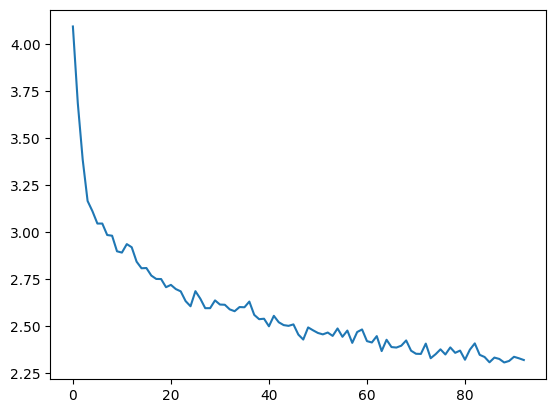

In [20]:
n = 1000
plt.plot(torch.tensor(all_loss[:len(all_loss) // n * n]).view(-1, n).mean(1))
plt.show()

In [24]:
import torch

@torch.no_grad()
def generate(model, block_size=8, start_token=0, generator=None, k=None, max_length=50):
    model.eval()
    
    # Initialize context window with `block_size` start tokens
    context = [start_token] * block_size  
    out = []

    for _ in range(max_length):  # Prevent infinite loops
        # Convert to tensor and ensure correct shape (batch_size=1)
        input_tensor = torch.tensor([context], dtype=torch.long).to(next(model.parameters()).device)

        # Forward pass through the model
        logits = model(input_tensor)[:, -1, :]  # Get logits for last token

        # Apply top-k filtering if needed
        if k:
            top_k_values, top_k_indices = torch.topk(logits, k)
            top_k_mask = torch.full_like(logits, float('-inf'))
            top_k_mask.scatter_(1, top_k_indices, top_k_values)
            logits = top_k_mask

        # Convert logits to probabilities
        p = torch.softmax(logits, dim=-1)

        # Sample next token
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()

        if ix == start_token:
            break  # Stop if we reach the start token (assuming it's also the EOS token)

        out.append(ix)

        # Update context window (keep last `block_size` tokens)
        context = context[1:] + [ix]

    return out


In [25]:
g = torch.Generator(device=device).manual_seed(42)
ids = generate(model, generator=g, k=10, max_length=2000)

print(tokenizer.decode(ids))

THB tur. Bis ale too here an shous wounding suthired the sourd hack wof ind angimse then where.

"E Thang botert
in dowiceat, soris oud wowich she ceayd the bered

roun to cid thet.
"THo foote fonere hings as ingtte at the bur thend ce insto frot thind is he sir cids, fedts the worn tor fury, the pairy and teas bout hiot at ste fot with.e AHowhas be sastre soo the

to anch bnd he stuls and the bong be to the was the dfand owat thenchard hel
eind
oole ound sthise sof thonged tise dt thir hie at inted he cit.e Aell

ishtels ond arsand a a shin oing.in the cay the chey the hey ad foutey han bre bas
the he calle thid
to ared, ott the had the deetteeder.
THO mur. The drsar. hem thom the ase wate wase cirg hilister sto to and bit the se culed hed boungess, and tf he helley hed casly found sromleyd thineng, fupel, wand hid are cus
rat bhed to fale be at stel fow atly hied fadimid her.


A the delland whinentoo hat thele, hasense hanged fheat,. wom whit ie the and.


he cinging hals he calayte

In [27]:
ids = generate(model, k=15, max_length=2000)

print(tokenizer.decode(ids))

 a tors and th and phe, that his the best heas wad no sellland thad. THH Mout he he mulil woon a boud atll

othernothis shed ping the

The, atder he to soallp.A
ST_I ander ins fof
onllonecerd

ath yor the dat of oo w wyot hisker sownish lhe poud tthe bat the bite was,it fong it hane and sore g of ans. FHE Tho
 founker hecirsey gop and
ics ros ayoay wety he
yowolledr ary dentithay hing he lns coingind. Ait the caind sh
hin out irs fom sug."

THE Brd
yomts. Mime, hay hiyd fret hone ang coul he did thide oumg the natt whem tomed the be lidt at ieller gas itll spedttoun, lintther wus forouthis oon owent ways ine chew aring fou the fat wooo fomter the coyldipds ang.

So ge wats blet sheat at and tig hersateng.


ho the dak aout.


he thanly we be mod te to tited the ther, on th on and tar at the cind this fnof rtims thame mousst and lofred the pild a male wffredr had, ont ool at lin shind heas thameds airst here am. hil mus celdn.a wou,g he suos ins shies, ftourket to hishen imkid nthe hitl